In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
from shapely.geometry import Point
import fiona
%matplotlib inline

## DOB permits

In [3]:
df_permits = pd.read_csv('C:/Users/shrey/Downloads/DOB_Permit_Issuance.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,8,9,10,15,31,33,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_permits.columns

Index(['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #', 'Job doc. #',
       'Job Type', 'Self_Cert', 'Block', 'Lot', 'Community Board', 'Zip Code',
       'Bldg Type', 'Residential', 'Special District 1', 'Special District 2',
       'Work Type', 'Permit Status', 'Filing Status', 'Permit Type',
       'Permit Sequence #', 'Permit Subtype', 'Oil Gas', 'Site Fill',
       'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date',
       'Permittee's First Name', 'Permittee's Last Name',
       'Permittee's Business Name', 'Permittee's Phone #',
       'Permittee's License Type', 'Permittee's License #',
       'Act as Superintendent', 'Permittee's Other Title', 'HIC License',
       'Site Safety Mgr's First Name', 'Site Safety Mgr's Last Name',
       'Site Safety Mgr Business Name', 'Superintendent First & Last Name',
       'Superintendent Business Name', 'Owner's Business Type', 'Non-Profit',
       'Owner's Business Name', 'Owner's First Name', 'Owner's Last Name',
 

In [5]:
df_permits.head(3)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BROOKLYN,3326733,1070,EAST 104 STREET,301064023,1,A2,Y,8230,1,...,NY,11101,7184728000,11/03/2017 12:00:00 AM,1238812,40.644203,-73.892264,46.0,986.0,Canarsie
1,BROOKLYN,3322563,230,HANCOCK STREET,302036375,1,A1,Y,1838,43,...,NV,11225,NaN,11/03/2017 12:00:00 AM,2471045,40.682849,-73.947219,36.0,249.0,Bedford
2,MANHATTAN,1040756,504,PARK AVENUE,100209846,1,A3,NaN,1374,36,...,NY,10017,2127542310,11/03/2017 12:00:00 AM,191966,40.763075,-73.969695,4.0,11401.0,Upper East Side-Carnegie Hill


#### Cleaning the DOB Permits Data
1. Considering relevant columns: 'BOROUGH','Permit Status','Issuance Date', 'Expiration Date','LATITUDE', 'LONGITUDE','CENSUS_TRACT'
2. Tranforming data to get columns in the right format and filtering by date (Sheds that went up in 2016)
3. Calculating duration for each sidewalk shed by: Expiration Date - Issuance Date
4. Considering sheds in MANHATTAN Borough only
4. Creating final dataframe by considering sheds up for more than 300 days

In [4]:
df_permits_short = df_permits[['BOROUGH','Permit Status','Issuance Date', 'Expiration Date','LATITUDE', 'LONGITUDE',\
                               'CENSUS_TRACT']]

In [62]:
print(type(df_permits_short['Issuance Date'].iloc[0]))
print(type(df_permits_short['Expiration Date'].iloc[0]))

<class 'str'>
<class 'str'>


In [64]:
## Converting 'Issuance Date' and 'Expiration Date' to Datetime
df_permits_short['Issuance Date'] = pd.to_datetime(df_permits_short['Issuance Date'])

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
df_permits_short['Expiration Date'] = pd.to_datetime(df_permits_short['Expiration Date'])

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [2]:
df_permits_short = pd.read_csv("DOB_Permits_Cleaned.csv")

In [3]:
# Sidewalk Sheds that went up in 2016
df_permits_2016 = df_permits_short[pd.to_datetime(df_permits_short['Issuance Date']).dt.year == 2016]

In [4]:
# TODO: Explain about 11 wrongly entered data having expiration data as 2020
df_permits_2016['Expiration Date'].max()

'2020-12-31'

In [5]:
#Removing entries with invalid expiration dates
df_permits_2016 = df_permits_2016[pd.to_datetime(df_permits_2016['Expiration Date']).dt.year == 2017]

In [6]:
# Sidewalk sheds in Manhattan
df_permits_mn = df_permits_2016[df_permits_2016['BOROUGH'] == 'MANHATTAN']

In [7]:
#df_permits_short.to_csv('DOB_Permits_Cleaned.csv')
df_permits_2016['duration'] = pd.to_datetime(df_permits_2016['Expiration Date']).dt.date - \
pd.to_datetime(df_permits_2016['Issuance Date']).dt.date

In [8]:
# Final dataframe after cleaning, transforming and filtering by dates/duration
df_permits_filtered = df_permits_2016[df_permits_2016['duration'] > pd.Timedelta('300 days')]

In [9]:
df_permits_filtered.shape

(117263, 9)

## Census Tract Shapefile
This will be used for plotting maps.

In [63]:
censustract = gpd.read_file('nyct2010wi.shp')

In [64]:
censustract.CT2010 = pd.to_numeric(censustract.CT2010)

In [65]:
censustract = censustract.rename(columns={'CT2010':'CENSUS_TRACT'})

In [10]:
censustract.head(3)

,CTLabel,BoroCode,BoroName,CENSUS_TRACT,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry
0,9,5,Staten Island,900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016666,2.497010e+06,"POLYGON ((961685.0524291991 172726.407592773, ..."
1,98,1,Manhattan,9800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199988,1.906016e+06,"POLYGON ((993521.2968139651 213744.264038086, ..."
2,100,1,Manhattan,10000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168417,1.860938e+06,"POLYGON ((992351.1254272461 214645.420593262, ..."


In [66]:
#Manhattan censustracts
censustract_mn = censustract[censustract['BoroName'] == 'Manhattan']

In [67]:
censustract_mn.shape

(288, 12)

## Plotting DOB Permits for 2016
### Sheds up for more than 300 days in Manhattan

In [ ]:
## Creating geodataframe for DOB permits

In [31]:
crs = {'init' :'epsg:4326'}

In [32]:
geometry = [Point(xy) for xy in zip(df_permits_filtered.LONGITUDE,df_permits_filtered.LATITUDE)]

In [33]:
df_permits_2016_gdb = gpd.GeoDataFrame(df_permits_filtered, geometry=geometry, crs=crs)

In [38]:
censustract_mn = censustract_mn.to_crs(epsg=4326)

In [39]:
df_permits_2016_with_censustract = gpd.sjoin(df_permits_2016_gdb,censustract_mn, how='inner', op='within' )

C:\Users\shrey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [50]:
df_permits_2016_with_censustract['duration'] = df_permits_2016_with_censustract['duration'].dt.days

In [79]:
df_permits_2016_with_censustract = df_permits_2016_with_censustract[df_permits_2016_with_censustract['duration']<=450]

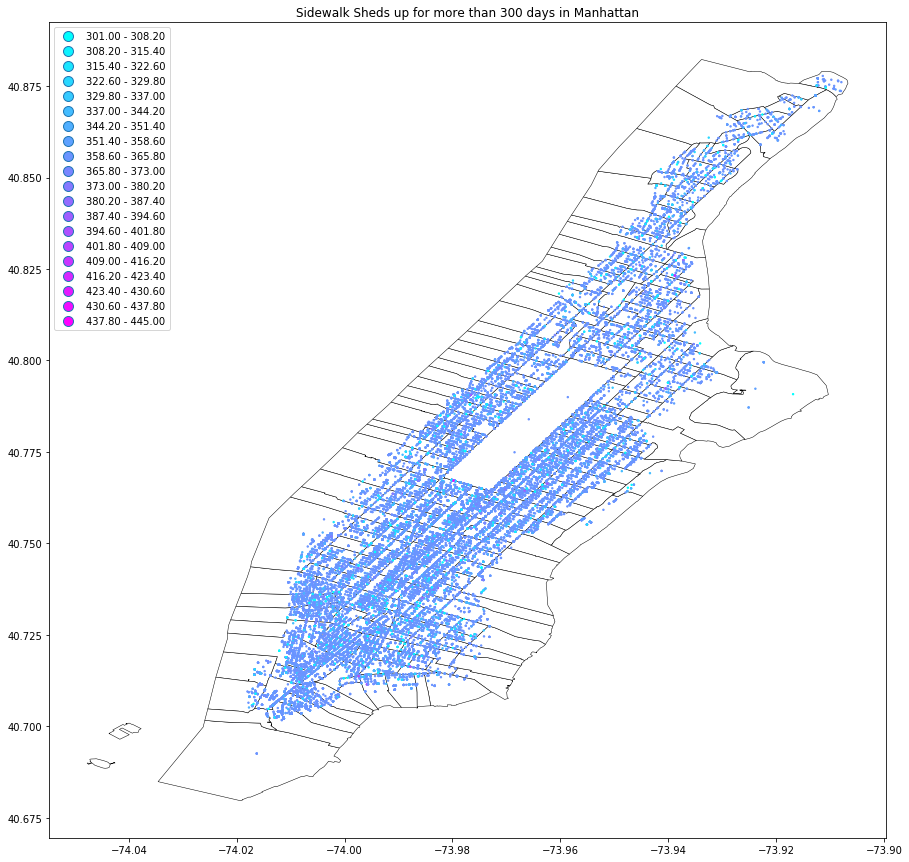

In [80]:
f, ax = pl.subplots(figsize=(15,15))
pl.title("Sidewalk Sheds up for more than 300 days in Manhattan")
censustract_mn.plot(ax=ax, color='white',edgecolor='black',lw=0.5)
df_permits_2016_with_censustract.plot(ax=ax,column='duration', scheme='Equal_interval',cmap='cool',k=20, legend=True,\
                                     markersize=2)

### Figure1: Sidewalk Sheds up for more than 300 days in Manhattan - Issuance Year 2016
#### [Most of the sidewalks are up for a year and very few can be seen for more than 365 days. 
#### The further analysis is done for these sidewalk sheds]

## DOB Violations

In [4]:
dob_violation = pd.read_csv('DOB_Violations.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dob_violation.columns

Index(['ISN_DOB_BIS_VIOL', 'BORO', 'BIN', 'BLOCK', 'LOT', 'ISSUE_DATE',
       'VIOLATION_TYPE_CODE', 'VIOLATION_NUMBER', 'HOUSE_NUMBER', 'STREET',
       'DISPOSITION_DATE', 'DISPOSITION_COMMENTS', 'DEVICE_NUMBER',
       'DESCRIPTION', 'ECB_NUMBER', 'NUMBER', 'VIOLATION_CATEGORY',
       'VIOLATION_TYPE'],
      dtype='object')

In [9]:
dob_violation['VIOLATION_TYPE'].value_counts()

E-ELEVATOR                                                       55187
AEUHAZ1-FAIL TO CERTIFY CLASS 1                                  27818
ACC1-(OTHER BLDGS TYPES) - ELEVATOR AFFIRMATION OF CORRECTION    27118
LBLVIO-LOW PRESSURE BOILER                                       16685
EVCAT1-ELEVATOR ANNUAL INSPECTION / TEST                         11866
C-CONSTRUCTION                                                    9397
BENCH-FAILURE TO BENCHMARK                                        6016
EVCAT5-NON-RESIDENTIAL ELEVATOR PERIODIC INSPECTION/TEST          3545
EARCX-FAILURE TO SUBMIT EER                                       2231
P-PLUMBING                                                        1641
LANDMK-LANDMARK                                                   1522
ACH1-(NYCHA) - ELEVATOR AFFIRMATION OF CORRECTION                 1428
JVIOS-PRIVATE RESIDENTIAL ELEVATOR                                1173
FISP-FACADE SAFETY PROGRAM                                        1146
HBLVIO

## 311 Data

In [24]:
# Reading in 311 data for 2016 and 2017
df_311_2016 = pd.read_csv('C:/Users/shrey/Downloads/311_2016_2017.csv')
df_311_2017 = pd.read_csv('C:/Users/shrey/Downloads/311_2017_2018.csv')
df_311_Jun2017 = pd.read_csv('C:/Users/shrey/Downloads/311_Jun2017_Jun2018.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8,17,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (8,17,18,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [100]:
df_311_2016['Status'].value_counts()

Closed              2227919
Pending               59876
Open                  34159
Assigned              26139
Started                 937
Email Sent              252
Closed - Testing         15
Unassigned                5
Unspecified               2
Draft                     2
Name: Status, dtype: int64

#### Cleaning the 311 Complaints Data
1. Considering relevant columns: 'Created Date', 'Closed Date','Complaint Type','Descriptor', 'Location Type','Borough','Latitude', 'Longitude'
2. Removing records with irrelevant complaint types: 'HEAT/HOT WATER','WATER LEAK','Derelict Vehicle','Derelict Vehicles','Animal Abuse','Overgrown Tree/Branches 
3. Considering top 50 complaint types
4. Filtering by Location as 'Street/Sidewalk' and 'Sidewalk'
5. Considering complaints in MANHATTAN Borough only

In [25]:
# Considering relevant columns
df_311_2016_short = df_311_2016[['Created Date', 'Closed Date','Complaint Type','Descriptor', 'Location Type','Borough',\
                                 'Latitude', 'Longitude']]
df_311_2017_short = df_311_2017[['Created Date', 'Closed Date','Complaint Type', 'Descriptor', 'Location Type','Borough',\
                                 'Latitude', 'Longitude']]

In [26]:
#Looking at complaints from June 2017 to Jun 2018 - as we want to find impacts after the scafolding
#has been up for a considerable period (6 months)
df_311_Jun2017_short = df_311_Jun2017[['Created Date', 'Closed Date','Complaint Type', 'Descriptor', 'Location Type',\
                                       'Borough','Latitude', 'Longitude']]

In [35]:
# List of non-relevavnt comaplint types
complaints_excluded = ['HEAT/HOT WATER','WATER LEAK','Derelict Vehicle','Derelict Vehicles','Animal Abuse',\
                       'Overgrown Tree/Branches ','Snow','Blocked Driveway']

In [43]:
df_311_2016_filtered = df_311_2016_short[~df_311_2016_short['Complaint Type'].isin(complaints_excluded)]
df_311_2017_filtered = df_311_2017_short[~df_311_2017_short['Complaint Type'].isin(complaints_excluded)]

In [37]:
df_311_Jun2017_filtered = df_311_Jun2017_short[~df_311_Jun2017_short['Complaint Type'].isin(complaints_excluded)]

In [44]:
#Considering service requests with location as Street/Sidewalk
df_311_2016_filtered = df_311_2016_filtered[(df_311_2016_filtered['Location Type'] == 'Street/Sidewalk')|\
                                           (df_311_2016_filtered['Location Type'] == 'Sidewalk')]

In [45]:
df_311_2017_filtered = df_311_2017_filtered[(df_311_2017_filtered['Location Type'] == 'Street/Sidewalk')|\
                                           (df_311_2017_filtered['Location Type'] == 'Sidewalk')]

In [46]:
df_311_Jun2017_filtered = df_311_Jun2017_filtered[(df_311_Jun2017_filtered['Location Type'] == 'Street/Sidewalk')|\
                                           (df_311_Jun2017_filtered['Location Type'] == 'Sidewalk')]

In [47]:
#Considering top 30 complaint types df_311_2016_short['Complaint Type'].value_counts()>threshold Jun-109, 2017-136, 2016-85
#Count of top 30th complaint = 86 for 2016
df_311_2016_filtered = df_311_2016_filtered.groupby(['Complaint Type']).filter(lambda x: len(x) > 85) 
#Count of top 50th complaint = 137 for 2017
df_311_2017_filtered = df_311_2017_filtered.groupby(['Complaint Type']).filter(lambda x: len(x) > 136)

In [48]:
df_311_Jun2017_filtered = df_311_Jun2017_filtered.groupby(['Complaint Type']).filter(lambda x: len(x) > 109)

In [51]:
print("Dimesnions of datasets after filtering:\n 311 2016: {}\n 311 2017: {} \n 311 Jun17-Jun18: {}"\
      .format(df_311_2016_filtered.shape, df_311_2017_filtered.shape, df_311_Jun2017_filtered.shape))

Dimesnions of datasets fater filtering:
 311 2016: (364469, 8)
 311 2017: (466288, 8) 
 311 Jun17-Jun18: (542323, 8)


### Saving Point 1

In [52]:
#df_311_2016_filtered.to_csv('df_311_2016_filtered.csv')
#df_311_2017_filtered.to_csv('df_311_2017_filtered.csv')
#df_311_Jun2017_filtered.to_csv('df_311_Jun2017_filtered.csv')

In [53]:
## Considering complaints only in MANHATTAN
df_311_2016_filtered = df_311_2016_filtered[df_311_2016_filtered['Borough'] == 'MANHATTAN']
df_311_2017_filtered = df_311_2017_filtered[df_311_2017_filtered['Borough'] == 'MANHATTAN']

In [54]:
df_311_Jun2017_filtered = df_311_Jun2017_filtered[df_311_Jun2017_filtered['Borough'] == 'MANHATTAN']

In [56]:
print("Dimesnions of datasets after cleaning:\n 311 2016: {}\n 311 2017: {} \n 311 Jun17-Jun18: {}"\
      .format(df_311_2016_filtered.shape, df_311_2017_filtered.shape, df_311_Jun2017_filtered.shape))

Dimesnions of datasets after cleaning:
 311 2016: (95003, 8)
 311 2017: (96978, 8) 
 311 Jun17-Jun18: (101104, 8)


In [ ]:
# Sampling to speed up processing --> to be done when processing for NYC
"""np.random.seed(99)
df_311_2016_sampled = df_311_2016_filtered.sample(n=int(df_311_2016_filtered.shape[0]/5), axis=0)
df_311_2017_sampled = df_311_2017_filtered.sample(n=int(df_311_2017_filtered.shape[0]/5), axis=0)

print(" New dimensions \n 311 2016 data: {} \n 311 2017 data: {}"\
      .format(df_311_2016_sampled.shape,df_311_2017_sampled.shape))""""""

## Comparing 311 data for - 
### 1. years 2016 and 2017
### 2. years 2016 and mid 2017 to mid 2018
#### Finding imapct of sidewalk sheds by analyzing counts of service requests in each census tract

#### The dataset from mid 2017 to mid 2018 is considered for following reasons - 
1. The issuance date of sidewalk sheds is 2016. Therefore, there are sheds that are put up till end of 2016.
2. Considering data only for 2017, does not account for impacts after the sidewalk shed is taken down

In [57]:
crs = {'init' :'epsg:4326'}

In [58]:
geometry = [Point(xy) for xy in zip(df_311_2016_filtered.Longitude,df_311_2016_filtered.Latitude)]

In [59]:
df_311_2016_gdb = gpd.GeoDataFrame(df_311_2016_filtered, geometry=geometry, crs=crs)

In [68]:
censustract_mn = censustract_mn.to_crs(epsg=4326)

In [69]:
df_311_2016_with_censustract = gpd.sjoin(df_311_2016_gdb,censustract_mn, how='inner', op='within' )

C:\Users\shrey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [70]:
geometry = [Point(xy) for xy in zip(df_311_2017_filtered.Longitude,df_311_2017_filtered.Latitude)]

In [71]:
df_311_2017_gdb = gpd.GeoDataFrame(df_311_2017_filtered, geometry=geometry, crs=crs)

In [72]:
df_311_2017_with_censustract = gpd.sjoin(df_311_2017_gdb,censustract_mn, how='inner', op='within' )

C:\Users\shrey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [73]:
geometry = [Point(xy) for xy in zip(df_311_Jun2017_filtered.Longitude,df_311_Jun2017_filtered.Latitude)]

In [74]:
df_311_Jun2017_gdb = gpd.GeoDataFrame(df_311_Jun2017_filtered, geometry=geometry, crs=crs)

In [75]:
df_311_Jun2017_with_censustract = gpd.sjoin(df_311_Jun2017_gdb,censustract_mn, how='inner', op='within' )

C:\Users\shrey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [77]:
print(" Dimensions after spatial join: \n 311 2016 data : {} \n 311 2017 data: {} \n 311 Jun17-Jun18: {}"\
      .format(df_311_2016_with_censustract.shape, df_311_2017_with_censustract.shape,\
              df_311_Jun2017_with_censustract.shape))

 Dimensions after spatial join: 
 311 2016 data : (93898, 21) 
 311 2017 data: (96134, 21) 
 311 Jun17-Jun18: (100312, 21)


In [79]:
df_311_2016_with_censustract_short = df_311_2016_with_censustract[['Complaint Type','CENSUS_TRACT']]
df_311_2017_with_censustract_short = df_311_2017_with_censustract[['Complaint Type','CENSUS_TRACT']]

In [102]:
df_311_Jun2017_with_censustract_short = df_311_Jun2017_with_censustract[['Complaint Type','CENSUS_TRACT']]

In [80]:
df_311_2016_with_censustract_short['complaint'] = 1
df_311_2017_with_censustract_short['complaint'] = 1

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
df_311_Jun2017_with_censustract_short['complaint']=1

C:\Users\shrey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
df_311_2016_groupby = df_311_2016_with_censustract_short.groupby(['CENSUS_TRACT','Complaint Type']).sum().reset_index()
df_311_2017_groupby = df_311_2017_with_censustract_short.groupby(['CENSUS_TRACT','Complaint Type']).sum().reset_index()

In [111]:
df_311_Jun2017_groupby = df_311_Jun2017_with_censustract_short.groupby(['CENSUS_TRACT','Complaint Type'])\
.sum().reset_index()

In [ ]:
df_permits_filtered.dropna(inplace=True)

In [107]:
df_permits_filtered.merge(df_311_2017_groupby, on='CENSUS_TRACT', how='left')

,Unnamed: 0,BOROUGH,Permit Status,Issuance Date,Expiration Date,LATITUDE,LONGITUDE,CENSUS_TRACT,duration,geometry,Complaint Type,complaint
0,4,MANHATTAN,ISSUED,2016-03-30,2017-03-30,40.747535,-73.986372,76,365 days,POINT (-73.986372 40.747535),NaN,NaN
1,60,MANHATTAN,ISSUED,2016-03-08,2017-02-10,40.736782,-73.993039,52,339 days,POINT (-73.993039 40.736782),NaN,NaN
2,88,BROOKLYN,ISSUED,2016-01-20,2017-01-19,40.683557,-73.980314,39,365 days,POINT (-73.98031400000001 40.683557),NaN,NaN
3,104,BROOKLYN,ISSUED,2016-08-10,2017-08-10,40.626680,-74.015120,206,365 days,POINT (-74.01512 40.62668),NaN,NaN
4,161,BROOKLYN,ISSUED,2016-03-31,2017-03-29,40.667705,-73.863018,1214,363 days,POINT (-73.86301800000003 40.667705),NaN,NaN
5,173,BROOKLYN,ISSUED,2016-03-31,2017-04-01,40.697272,-73.977450,211,366 days,POINT (-73.97745 40.697272),NaN,NaN
6,174,QUEENS,ISSUED,2016-05-20,2017-05-20,40.762471,-73.831681,869,365 days,POINT (-73.831681 40.76247100000001),NaN,NaN
7,188,QUEENS,ISSUED,2016-07-05,2017-06-30,40.755141,-73.928728,55,360 days,POINT (-73.92872800000001 40.755141),NaN,NaN
8,213,QUEENS,ISSUED,2016-06-23,2017-06-23,40.744543,-73.720619,157101,365 days,POINT (-73.720619 40.744543),NaN,NaN
9,218,MANHATTAN,ISSUED,2016-07-15,2017-07-14,40.751098,-73.992926,101,364 days,POINT (-73.992926 40.751098),NaN,NaN


#### Normalizing complaint counts per Census Tract by number by total number of service requests in that Census tract

In [88]:
def calculate_total_complaints(df):
    ct = df.CENSUS_TRACT.unique()
    # Calculating vector of relative frequencies for each census tract
    #S_a = {}
    # Calculating total complaints for each census tract
    ct_complaints = {}

    for census_tract in ct:
        df_temp = df[df['CENSUS_TRACT'] == census_tract]
        s_area = np.sum(df_temp.complaint)      # total number of service requests in an area
        ct_complaints[census_tract] = s_area
    
    return ct_complaints
        #S_a[census_tract] = list(df_temp.complaint/s_area)

In [156]:
def normalize_complaint_counts(df):
    ct = df.CENSUS_TRACT.unique()
    #Calculating vector of relative frequencies for each census tract
    S_a = {}

    for census_tract in ct:
        df_temp = df[df['CENSUS_TRACT'] == census_tract]
        s_area = np.sum(df_temp.complaint)      # total number of service requests in an area
        S_a[census_tract] = list(df_temp.complaint/s_area)
    
    return S_a

In [89]:
df_2016_complaint_counts = pd.DataFrame.from_dict(calculate_total_complaints(df_311_2016_groupby), orient='index')

In [91]:
df_2017_complaint_counts = pd.DataFrame.from_dict(calculate_total_complaints(df_311_2017_groupby), orient='index')

In [112]:
df_Jun2017_complaint_counts = pd.DataFrame.from_dict(calculate_total_complaints(df_311_Jun2017_groupby), orient='index')

In [149]:
df_2016_complaint_counts.reset_index().index

RangeIndex(start=0, stop=286, step=1)

In [114]:
#Merging with 2016 dataframe to compare counts
temp1 = df_2016_complaint_counts.reset_index()
temp2 = df_2017_complaint_counts.reset_index()

df_merge_2016_2017 = temp1.merge(temp2, on='index', how='inner')

temp1 = df_2016_complaint_counts.reset_index()
temp2 = df_Jun2017_complaint_counts.reset_index()

df_merge_2016_Jun2017 = temp1.merge(temp2, on='index', how='inner')

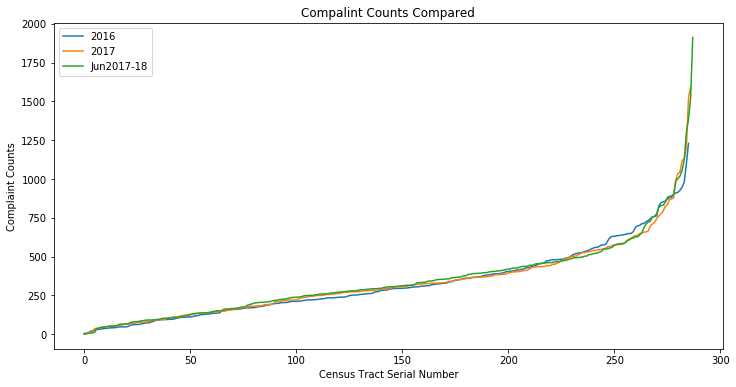

In [181]:
fig = pl.figure(figsize=(12,6))
#df_merge_2016_2017['0_x'].plot(c='red')
#df_merge_2016_Jun2017['0_y'].plot(c='blue')
#df_merge_2016_2017['0_y'].plot(c='green')
#pl.subplot(211)
#pl.bar(df_2016_complaint_counts.reset_index().index,df_2016_complaint_counts[0], alpha=0.7, color='green')
#pl.subplot(212)
#pl.bar(df_2017_complaint_counts.reset_index().index,df_2017_complaint_counts[0])
pl.title("Compalint Counts Compared")
pl.plot(df_2016_complaint_counts.reset_index().index, df_2016_complaint_counts[0].sort_values(), label='2016')
pl.plot(df_2017_complaint_counts.reset_index().index, df_2017_complaint_counts[0].sort_values(),label='2017')
pl.plot(df_Jun2017_complaint_counts.reset_index().index, df_Jun2017_complaint_counts[0].sort_values(), label='Jun2017-18')
pl.xlabel("Census Tract Serial Number")
pl.ylabel("Complaint Counts")
pl.legend()

#### Clustering was being considered to find anamalous census tracts that have sudden increase in number of comaplints. This appaorach did not work out that well. But still effort is amde to use these results if relevant in our analysis

In [25]:
df_311_2016_features = pd.DataFrame.from_dict(S_a, orient='index')

In [26]:
df_311_2016_features = df_311_2016_features.fillna(0)

In [27]:
ct = df_311_2017_groupby.CENSUS_TRACT.unique()
# Calculating vector of relative frequencies for each census tract
S_a = {}

for census_tract in ct:
    df_temp = df_311_2017_groupby[df_311_2017_groupby['CENSUS_TRACT'] == census_tract]
    s_area = np.sum(df_temp.complaint)      # total number of service requests in an area
    S_a[census_tract] = list(df_temp.complaint/s_area)

In [28]:
df_311_2017_features = pd.DataFrame.from_dict(S_a, orient='index')

In [29]:
df_311_2017_features = df_311_2017_features.fillna(0)

#### Choosing number of clusters

In [30]:
range_n_clusters = range(2,10)

for n_clusters in range_n_clusters:
    km = KMeans(random_state=99,n_clusters=n_clusters)
    res=km.fit(df_311_2016_features)
    cluster_labels = res.labels_
    silhouette_avg = silhouette_score(df_311_2016_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.15591697286742595
For n_clusters = 3, the average silhouette_score is : 0.09009054544887078
For n_clusters = 4, the average silhouette_score is : 0.05923852096141315
For n_clusters = 5, the average silhouette_score is : 0.05806217567728139
For n_clusters = 6, the average silhouette_score is : 0.05853902772771751
For n_clusters = 7, the average silhouette_score is : 0.055063757108723785
For n_clusters = 8, the average silhouette_score is : 0.06537761139762041
For n_clusters = 9, the average silhouette_score is : 0.07546824624845427


[77.57702582597372, 73.79605413723542, 71.04838090619421, 68.67766331820951, 66.45123212217113, 64.9735293756197, 63.30948704339898, 61.073033230660144]


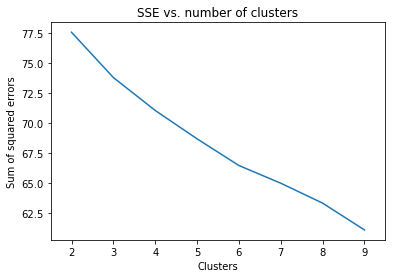

In [31]:
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(df_311_2016_features)
    SSE.append(res.inertia_)
print(SSE)

pl.gca()
pl.plot(range(2,10),SSE)
pl.xlabel("Clusters")
pl.ylabel("Sum of squared errors")
pl.title("SSE vs. number of clusters")
pl.xlim(1.5,9.5)
pl.show()

In [38]:
km = KMeans(random_state=99,n_clusters=3)
res_2016=km.fit(df_311_2016_features)
res_2017=km.fit(df_311_2017_features)

In [39]:
df_311_2016_clusters = pd.DataFrame(df_311_2016_features.reset_index()['index'])
df_311_2017_clusters = pd.DataFrame(df_311_2017_features.reset_index()['index'])

In [40]:
df_311_2016_clusters['cluster'] = res_2016.labels_
df_311_2017_clusters['cluster'] = res_2017.labels_

In [41]:
df_311_2016_clusters.rename(columns={'index':'CENSUS_TRACT'}, inplace=True)
df_311_2017_clusters.rename(columns={'index':'CENSUS_TRACT'}, inplace=True)

In [211]:
censustract.merge(df_311_clusters, on='CENSUS_TRACT',how='left')

,CTLabel,BoroCode,BoroName,CENSUS_TRACT,BoroCT2010,CDEligibil,NTACode,NTAName,PUMA,Shape_Leng,Shape_Area,geometry,cluster
0,9,5,Staten Island,000900,5000900,I,SI22,West New Brighton-New Brighton-St. George,3903,7729.016666,2.497010e+06,POLYGON ((-74.08130714211008 40.64074191709274...,2.0
1,98,1,Manhattan,009800,1009800,I,MN19,Turtle Bay-East Midtown,3808,5534.199988,1.906016e+06,POLYGON ((-73.96653673334281 40.75335025612635...,2.0
2,100,1,Manhattan,010000,1010000,I,MN19,Turtle Bay-East Midtown,3808,5692.168417,1.860938e+06,POLYGON ((-73.97075919418829 40.75582485124249...,2.0
3,102,1,Manhattan,010200,1010200,I,MN17,Midtown-Midtown South,3807,5687.802440,1.860993e+06,"POLYGON ((-73.97398183196347 40.7571797580858,...",0.0
4,104,1,Manhattan,010400,1010400,I,MN17,Midtown-Midtown South,3807,5693.035870,1.864600e+06,POLYGON ((-73.97720026523596 40.75853793354626...,2.0
5,113,1,Manhattan,011300,1011300,I,MN17,Midtown-Midtown South,3807,5699.860888,1.890907e+06,POLYGON ((-73.98548819085713 40.75293517965362...,2.0
6,114.02,1,Manhattan,011402,1011402,I,MN40,Upper East Side-Carnegie Hill,3805,4125.256348,1.063547e+06,POLYGON ((-73.96612747295728 40.76217929969562...,2.0
7,130,1,Manhattan,013000,1013000,I,MN40,Upper East Side-Carnegie Hill,3805,5807.973028,1.918145e+06,POLYGON ((-73.96431940640112 40.77042295736221...,2.0
8,140,1,Manhattan,014000,1014000,I,MN40,Upper East Side-Carnegie Hill,3805,5820.815890,1.925984e+06,POLYGON ((-73.95779380470225 40.77359989745678...,2.0
9,148.01,1,Manhattan,014801,1014801,I,MN40,Upper East Side-Carnegie Hill,3805,3135.951423,5.592162e+05,POLYGON ((-73.95448224114996 40.77813866451909...,2.0


C:\Users\shrey\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


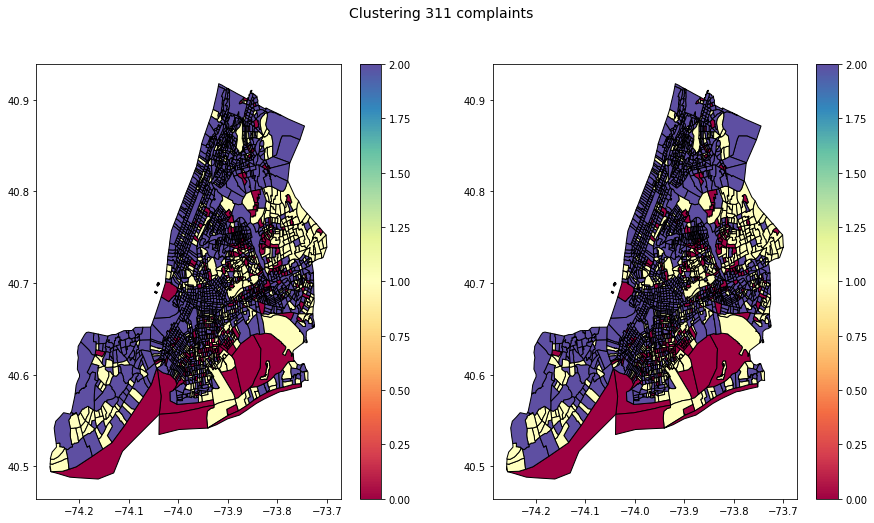

In [42]:
f, ax = pl.subplots(figsize=(15,8))
#censustractSHAPE.plot(ax=ax, color='white')
pl.suptitle('Clustering 311 complaints', fontsize=14)
ax1 = pl.subplot(121)
censustract.merge(df_311_2016_clusters, on='CENSUS_TRACT',how='left').plot(ax=ax1, cmap='Spectral',legend=True,column='cluster',edgecolor='black')
ax1 = pl.subplot(122)
censustract.merge(df_311_2017_clusters, on='CENSUS_TRACT',how='left').plot(ax=ax1, cmap='Spectral',legend=True,column='cluster',edgecolor='black')
#pl.savefig('Clustering_311.png')

In [44]:
df_311_2016_with_cluster = df_311_2016_with_censustract_short.merge(df_311_2016_clusters)

In [50]:
df_311_2017_with_cluster = df_311_2017_with_censustract_short.merge(df_311_2017_clusters)

In [45]:
temp_df = df_311_2016_with_cluster.drop(['CENSUS_TRACT','complaint'],axis=1).groupby(['cluster']).sum().reset_index() 

## NYPD Crime Data

In [5]:
nypd_df = pd.read_csv('C:/Users/shrey/Downloads/NYPD_Complaint_Data_Historic.csv')

C:\Users\shrey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
nypd_df.head(3)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"


In [14]:
nypd_df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [6]:
# Converting strings in date column to datetime
nypd_df['CMPLNT_FR_DT'] = pd.to_datetime(nypd_df['CMPLNT_FR_DT'],  errors = 'coerce')

In [7]:
# Dropping NaT values
nypd_df['CMPLNT_FR_DT'] = nypd_df['CMPLNT_FR_DT'].dropna()

In [8]:
nypd_df.dropna(inplace=True)

In [9]:
nypd_df_short = nypd_df[(nypd_df['CMPLNT_FR_DT'] > '01/01/2012') & (nypd_df['CMPLNT_FR_DT']<'12/31/2015')]

## Clustering NYPD Crime Data

In [10]:
crs = {'init' :'epsg:4326'}

In [12]:
geometry = [Point(xy) for xy in zip(nypd_df_short.Longitude,nypd_df_short.Latitude)]

In [13]:
nypd_df_gdb = gpd.GeoDataFrame(nypd_df_short, geometry=geometry, crs=crs)

In [14]:
censustract = censustract.to_crs(epsg=4326)

In [17]:
nypd_df_with_censustract = gpd.sjoin(nypd_df_gdb,censustract, how='left', op='within' )

In [19]:
nypd_df_short.shape

(115, 25)

In [20]:
nypd_df_with_censustract_short = nypd_df_with_censustract[['OFNS_DESC','CENSUS_TRACT']]

In [21]:
nypd_df_with_censustract_short['crime'] = 1

In [22]:
nypd_groupby = nypd_df_with_censustract_short.groupby(['CENSUS_TRACT','OFNS_DESC']).sum()

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}